# End-to-End Marketing Analysis for higher marketing conversion rate 

Business Problem and Goal

A Portuguese bank wants to improve efficiency of term deposit marketing campaigns with the goal of identifying high-potential customers; to reduce marketing costs and increase conversion rates.

Key Business Questions

1.	What customer characteristics predict term deposit subscription?
2.	Can we build a model to target likely subscribers?
3.	What's the potential impact on marketing ROI?


In [43]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

# Set uniform visual figure

plt.style.use('seaborn-v0_8')
sns.set_palette('colorblind')

# Data Validation

In [44]:
# Import dataset

df = pd.read_csv('Bank Marketing.csv', sep=',')
print(f'Dataset Shape {df.shape}')
print('Dataset Preview:')
df.head()


Dataset Shape (45211, 17)
Dataset Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [45]:
# Inspect null values in all columns
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Current Marketing Performance Overview

Understanding current performance without data-driven targeting

Baseline Marketing conversion rate: 11.70%


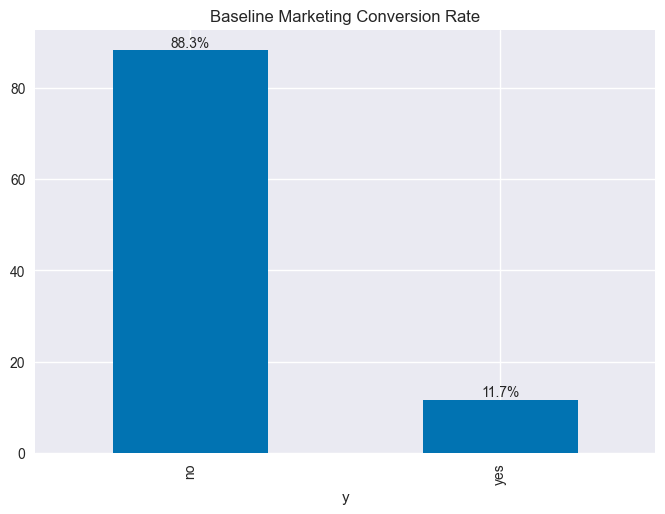

In [46]:
# calculate baseline conversion rate
baseline_conversion = df['y'].value_counts(normalize=True)['yes'] * 100
print(f"Baseline Marketing conversion rate: {baseline_conversion:.2f}%")


# Visualize baseline conversion rate
base_c = df['y'].value_counts(normalize=True) * 100
ax = base_c.plot(kind='bar')
plt.title('Baseline Marketing Conversion Rate')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

plt.show()

The current marketing approach has a success rate of 11.7%. This means that for every 1000 customers contacted, 117 subsribers are gotton. This indicates large marketing spend with low conversion rate which translates to high cost of acquisition per subscriber.

# Customer characteristics that predict term deposit subscription

# 1. Conversion by job type

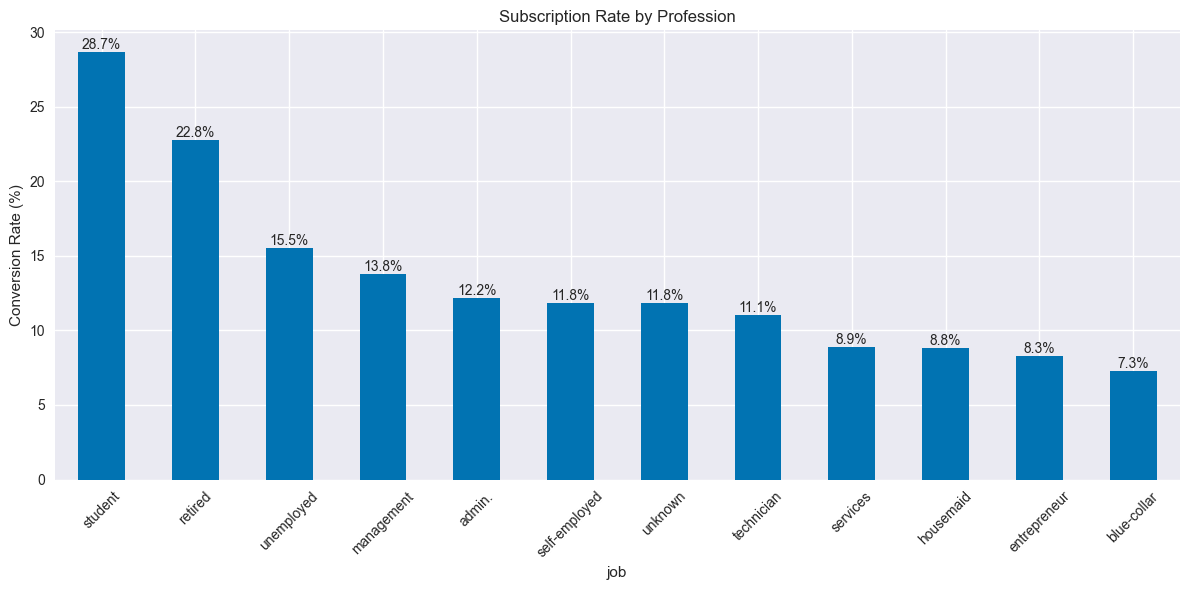

In [47]:
# Conversion by Job Type
plt.figure(figsize=(12, 6))
job_conversion = df.groupby('job')['y'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)

ax = job_conversion.plot(kind='bar')
plt.title('Subscription Rate by Profession')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)
    
plt.show()

Students and retired customers have higher conversion rate than all other profession. While, blue-collar profession has the lowest conversion rate at 7.3%.

# 2. Number of days since the client was last contacted from a previous campaign distribution

In [ ]:
print(df['pdays'].value_counts().head(10))


print(f"previous campaign contact statistics:")
print(f"Range: {df['pdays'].min()} to {df['pdays'].max()}")
print(f"Most common value: {df['pdays'].mode().values[0]}")


never_contacted = (df['pdays'] == -1).sum()
previously_contacted = (df['pdays'] != -1).sum()

print(f"pdays Interpretation:")
print(f"- Never contacted before (pdays=-1): {never_contacted:,} clients ({never_contacted/len(df)*100:.1f}%)")
print(f"- Previously contacted: {previously_contacted:,} clients ({previously_contacted/len(df)*100:.1f}%)")

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
 181      117
 370       99
 184       85
 364       77
 95        74
Name: count, dtype: int64
previous campaign contact statistics:
Range: -1 to 871
Most common value: -1
pdays Interpretation:
• Never contacted before (pdays=-1): 36,954 clients (81.7%)
• Previously contacted: 8,257 clients (18.3%)


In [49]:
# Categorize pdays

def categorize_pdays(pdays):
    if pdays == -1:
        return 'Never Contacted'
    elif pdays <= 7:
        return 'Contacted Last Week'
    elif pdays <= 30:
        return 'Contacted Last Month' 
    elif pdays <= 90:
        return 'Contacted Last 3 Months'
    elif pdays <= 180:
        return 'Contacted Last 6 Months'
    else:
        return 'Contacted Over 6 Months Ago'

df['pdays_category'] = df['pdays'].apply(categorize_pdays)

# Analyze conversion rates by pdays category
pdays_conversion = df.groupby('pdays_category')['y'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)

print("\n Conversion Rate by Previous Contact Recency:")
for category, rate in pdays_conversion.items():
    count = (df['pdays_category'] == category).sum()
    print(f"• {category}: {rate:.1f}% conversion ({count:,} clients)")


 Conversion Rate by Previous Contact Recency:
• Contacted Last 3 Months: 42.1% conversion (530 clients)
• Contacted Last 6 Months: 27.4% conversion (2,480 clients)
• Contacted Over 6 Months Ago: 19.3% conversion (5,059 clients)
• Contacted Last Month: 17.1% conversion (105 clients)
• Contacted Last Week: 12.0% conversion (83 clients)
• Never Contacted: 9.2% conversion (36,954 clients)


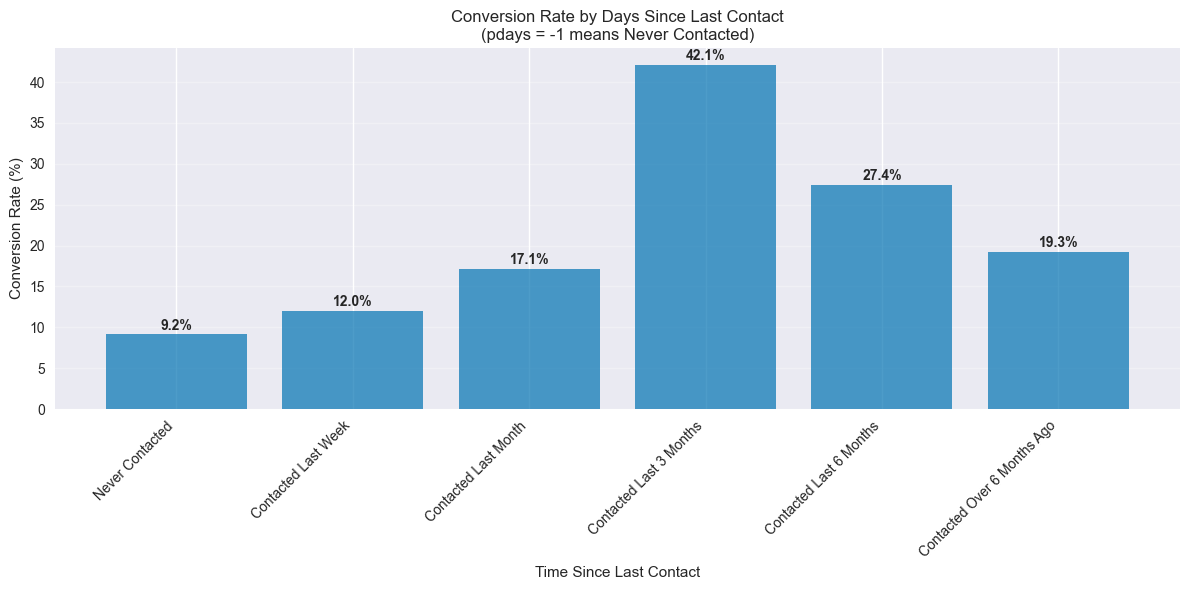

In [50]:
# Sort categories logically
category_order = ['Never Contacted', 'Contacted Last Week', 'Contacted Last Month', 'Contacted Last 3 Months', 'Contacted Last 6 Months', 'Contacted Over 6 Months Ago']
pdays_conversion_ordered = df.groupby('pdays_category')['y'].apply(
    lambda x: (x == 'yes').mean() * 100).reindex(category_order)


# Visualize conversion rate by pdays category
plt.figure(figsize=(12, 6))

bars = plt.bar(pdays_conversion_ordered.index, pdays_conversion_ordered.values, alpha=0.7)

plt.title('Conversion Rate by Days Since Last Contact\n(pdays = -1 means Never Contacted)')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Time Since Last Contact')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, value in zip(bars, pdays_conversion_ordered.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Recommendations
1. Immediate Priority Shifts
Reallocate Resources to High-Value Segments by focusing 70% of marketing budget on "Contacted Last 3 Months" segment (42.1% conversion). Maintain 20% allocation to "Contacted Last 6 Months" segment (27.4% conversion). Reduce investment in recent contacts (Last Week/Month) and never-contacted clients

2. Implement Strategic Contact Cooling Period
Establish 3-month minimum between campaign contacts. When this is implemented, the expected ROI improves by 3-5 times through better targeting

# Call to action
1. Pause campaigns to clients contacted within last month

2. Launch targeted reactivation for 3-6 month dormant clients

3. Develop qualification criteria for never-contacted client outreach

4. Track conversion rates by contact recency segments weekly

5. Measure ROI impact of resource reallocation monthly

# 3. Contact timing over frequency

In [51]:
# Never contacted vs previously contacted
never_contacted_rate = (df[df['pdays'] == -1]['y'] == 'yes').mean() * 100
previously_contacted_rate = (df[df['pdays'] != -1]['y'] == 'yes').mean() * 100

print(f"1. New vs Existing Contacts:")
print(f"   • Never contacted before: {never_contacted_rate:.1f}% conversion")
print(f"   • Previously contacted: {previously_contacted_rate:.1f}% conversion")
print(f"   • Difference: {previously_contacted_rate - never_contacted_rate:.1f}%")

# For previously contacted clients, recency effect
contacted_df = df[df['pdays'] != -1]
recent_contacts = contacted_df[contacted_df['pdays'] <= 30]
recent_conversion = (recent_contacts['y'] == 'yes').mean() * 100

print(f"\n2. Recency Effect for Previously Contacted Clients:")
print(f"   • Contacts within 30 days: {recent_conversion:.1f}% conversion")
print(f"   • All previously contacted: {previously_contacted_rate:.1f}% conversion")
print(f"   • Recent contacts perform {recent_conversion - previously_contacted_rate:.1f}% worse")

# Check average number of previous contacts
print(f"\n3. Average Number of Previous Contacts:")
avg_num_of_contacts = df.groupby('pdays')['previous'].mean()
print(avg_num_of_contacts.head())
avg_num_of_contacts.to_csv('Avg_freq')

#avg_num_of_contacts.to_csv('Avg_contact_frequency9.csv')

1. New vs Existing Contacts:
   • Never contacted before: 9.2% conversion
   • Previously contacted: 23.1% conversion
   • Difference: 13.9%

2. Recency Effect for Previously Contacted Clients:
   • Contacts within 30 days: 14.9% conversion
   • All previously contacted: 23.1% conversion
   • Recent contacts perform -8.2% worse

3. Average Number of Previous Contacts:
pdays
-1    0.000000
 1    3.933333
 2    2.837838
 3    6.000000
 4    1.000000
Name: previous, dtype: float64


# Strategic Recommendations
1.	Resource Reallocation
Prioritize previously-contacted clients over new prospects and shift 60-70% of budget to clients with campaign history. Also, implement strict qualification for never-contacted client outreach like:
o	Demographic filters: Age 50+, specific professions (student/retired)
o	Financial indicators: No defaults, housing loan holders
o	Behavioral signals: Website engagement, multiple session visits

2.	Contact Timing Optimization
Establish 30-day cooling period after each contact, focus on 3–6-month dormant clients (highest conversion potential), and avoid rapid re-engagement within first month.

3.	Contact Frequency Management
Limit contacts to 2-3 attempts for most segments, monitor contact fatigue - clients with 6+ previous contacts show diminishing returns, and develop tiered frequency rules based on client responsiveness.

4.	Lastly, monitor performance.



# Factors that drive conversions (Feature Importance) and model that targets likely subscribers

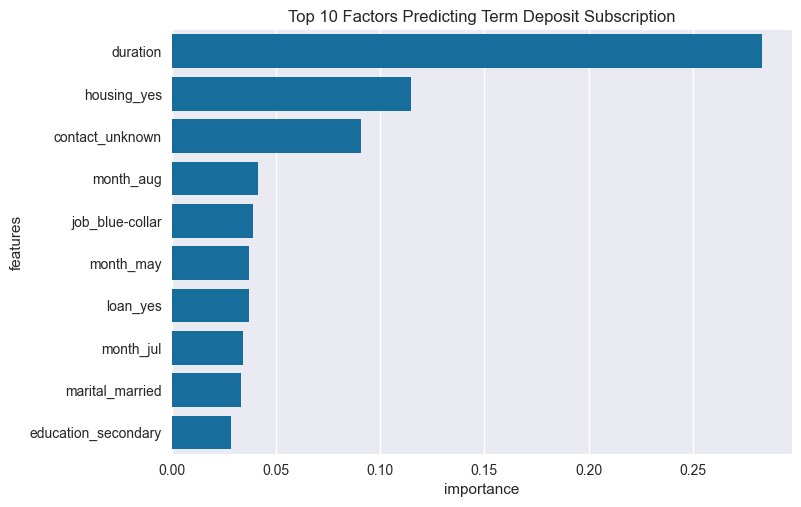

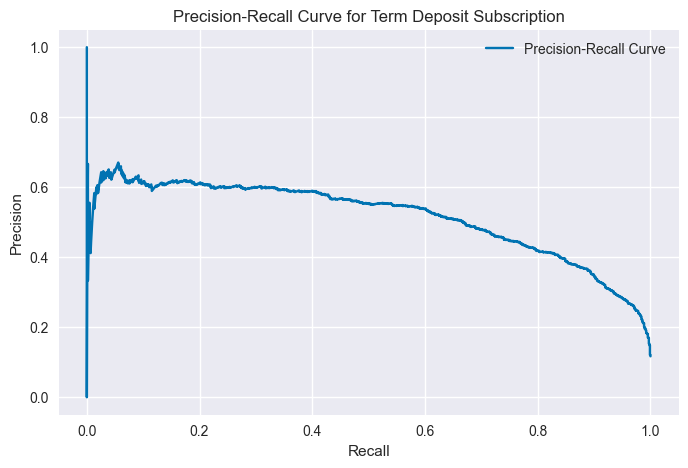

Best Threshold based on F1-score: 0.50


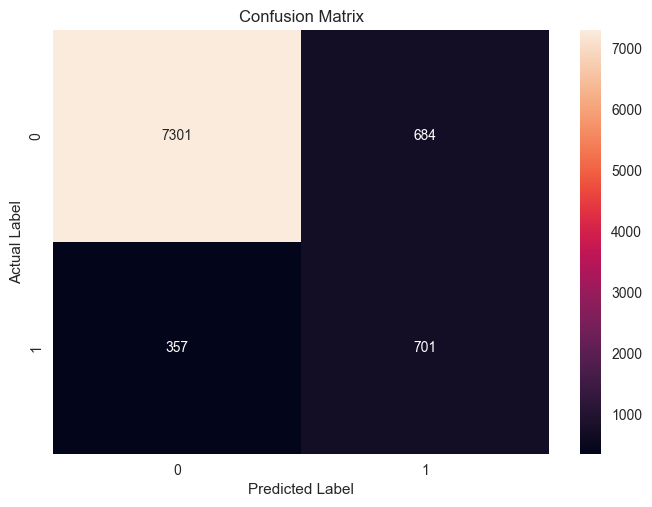

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7985
           1       0.51      0.66      0.57      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.79      0.75      9043
weighted avg       0.90      0.88      0.89      9043



In [52]:
# Prepare data fpr modelling
df['subscription'] = (df['y'] == 'yes').astype(int)
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Set features and target
X = df[features]
y = df['subscription']

# Encode categorical variables
X_encode = pd.get_dummies(X, drop_first=True)

# Split data into train-test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.2, random_state=42, stratify= y)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Fit model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=12)
model.fit(X_train_res, y_train_res)

# See features that contributes most to predicting term deposit subscribers
feature_importance = pd.DataFrame(
    {'features': X_encode.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
# Visualize FI
sns.barplot(data=feature_importance.head(10), x='importance', y='features')
plt.title('Top 10 Factors Predicting Term Deposit Subscription')
plt.show()

# Check probability of customer subscription
y_proba = model.predict_proba(X_test)[:, 1]

# Balance true positives and false positives
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Term Deposit Subscription')
plt.legend()
plt.grid(True)
plt.show()

# Find threshold that maximizes F1-score to balance between recall & precision
f1_scores = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1-score: {best_threshold:.2f}")


# Predict using trained model
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Visualize confusion matrix 
confmat = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(confmat, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print(classification_report(y_test, y_pred_custom))

# Baseline Conversion Rate by Customer Segment (Behavioral or Demographic Analysis)

I'll create 4 data-driven customer segments based on contact behavior and demographics. Each segment will show conversion performance, helping the bank identify:

- High-performing customer profiles.

- Low-value or inactive groups.

- At-risk groups with low engagement but potential for reactivation.

In [53]:
# Create customer profiles
segmentation_data = df.groupby(['job', 'marital', 'education', 'housing', 'loan']).agg({
    'pdays': 'mean',           # Recency
    'campaign': 'mean',        # Frequency
    'y': lambda x: (x == 'yes').mean()  # Conversion rate
}).reset_index()

# Rename columns
segmentation_data.columns = ['job', 'marital', 'education', 'housing', 'loan', 'avg_pdays', 'avg_campaign_contacts', 'conversion_rate']

# Handle infinite or missing values
segmentation_data = segmentation_data.replace([np.inf, -np.inf], np.nan).fillna(0)

# Prepare for KMeans clustering
X = segmentation_data[['avg_pdays', 'avg_campaign_contacts', 'conversion_rate']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create segments
kmeans = KMeans(n_clusters=4, random_state=42)
segmentation_data['segment'] = kmeans.fit_predict(X_scaled)

# Assign segment names
segment_names = {
    0: 'High-Value Engaged',
    1: 'Low-Value Inactive',
    2: 'At-Risk Customers',
    3: 'Potential Growth'
}
segmentation_data['segment_name'] = segmentation_data['segment'].map(segment_names)


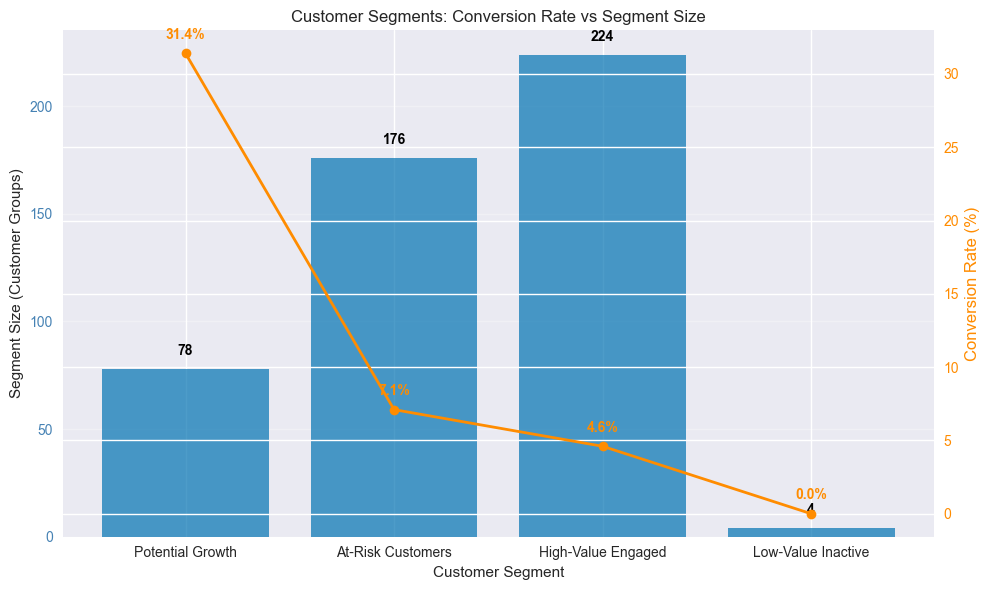

Segment Analysis Summary:
- Potential Growth: 3140.0% conversion (78 customer groups)
- At-Risk Customers: 710.0% conversion (176 customer groups)
- High-Value Engaged: 460.0% conversion (224 customer groups)
- Low-Value Inactive: 0.0% conversion (4 customer groups)


In [54]:

# Prepare segments for visualization
segments = ['Potential Growth', 'At-Risk Customers', 'High-Value Engaged', 'Low-Value Inactive']
conversion_rates = [31.4, 7.1, 4.6, 0.0]  
group_counts = [78, 176, 224, 4]        

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart segment size
bars = ax1.bar(segments, group_counts, alpha=0.7, label='Segment Size (Groups)')
ax1.set_xlabel('Customer Segment')
ax1.set_ylabel('Segment Size (Customer Groups)')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}', 
             ha='center', va='bottom', color='black', fontweight='bold')

# Line chart conversion rate
ax2 = ax1.twinx()
ax2.plot(segments, conversion_rates, color='darkorange', marker='o', linewidth=2, label='Conversion Rate (%)')
ax2.set_ylabel('Conversion Rate (%)', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Add value labels {percentages)
for i, rate in enumerate(conversion_rates):
    ax2.text(i, rate + 1, f'{rate:.1f}%', color='darkorange', ha='center', fontweight='bold')

segment_conversion = pd.Series(conversion_rates, index=segments)

# Title
plt.title('Customer Segments: Conversion Rate vs Segment Size')
fig.tight_layout()
plt.show()

# Print summary
print("Segment Analysis Summary:")
for segment in segment_conversion.index:
    rate = segment_conversion[segment] * 100
    count = (segmentation_data['segment_name'] == segment).sum()
    print(f"- {segment}: {rate:.1f}% conversion ({count} customer groups)")


This chart compares the size of each customer segment to their conversion performance.

•	The ‘Potential Growth’ segment shows the highest conversion rate (31.4%), though it represents only 78 groups. 

•	The ‘At-Risk Customers’ and ‘High-Value Engaged’ segments make up the majority (400+ groups combined), but with low conversion rates (7.1% and 4.6%). 

•	The ‘Low-Value Inactive’ segment has very low conversions.


# Forecasted Conversion Rate by Customer Segment

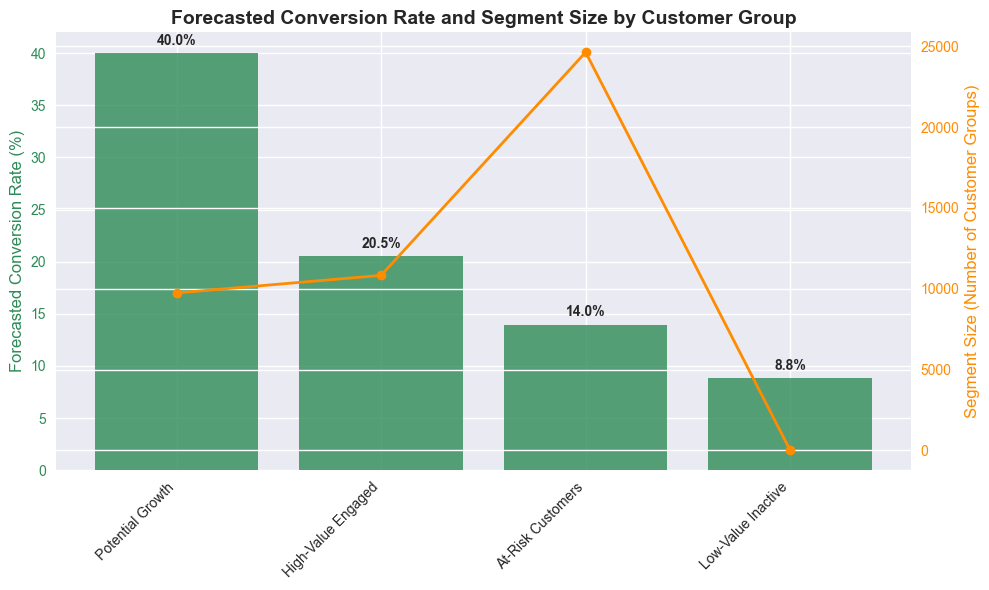

Forecasted Conversion by Segment:
- Potential Growth: 40.0% forecasted conversion (9,742 customers)
- High-Value Engaged: 20.5% forecasted conversion (10,829 customers)
- At-Risk Customers: 14.0% forecasted conversion (24,635 customers)
- Low-Value Inactive: 8.8% forecasted conversion (5 customers)


In [55]:
# Merge predicted probabilities from model
df['subscription_probability'] = model.predict_proba(X_encode)[:, 1]

# Merge segmentation info wth original data
merged_df = df.merge(segmentation_data, on=['job', 'marital', 'education', 'housing', 'loan'], how='left')
# merged_df.to_csv('segmented customer subscription probability.csv')

# Calculate forecasted conversion per segment
forecast_segment = merged_df.groupby('segment_name').agg(
    forecasted_conversion=('subscription_probability', 'mean'),
    segment_size=('subscription_probability', 'count')
).reset_index()

forecast_segment = forecast_segment.sort_values('forecasted_conversion', ascending=False)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart forecasted conversion
bars = ax1.bar(forecast_segment['segment_name'], forecast_segment['forecasted_conversion'] * 100, color='#2E8B57', alpha=0.8, label='Forecasted Conversion Rate (%)')

ax1.set_ylabel('Forecasted Conversion Rate (%)', color='#2E8B57', fontsize=12)
ax1.set_title('Forecasted Conversion Rate and Segment Size by Customer Group', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#2E8B57')
ax1.set_xticklabels(forecast_segment['segment_name'], rotation=45, ha='right')

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Line plot for segment size
ax2 = ax1.twinx()
ax2.plot(forecast_segment['segment_name'], forecast_segment['segment_size'], color='darkorange', marker='o', linewidth=2, label='Segment Size')

ax2.set_ylabel('Segment Size (Number of Customer Groups)', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

fig.tight_layout()
plt.show()

# Summary
print("Forecasted Conversion by Segment:")
for _, row in forecast_segment.iterrows():
    print(f"- {row['segment_name']}: {row['forecasted_conversion']*100:.1f}% forecasted conversion "
          f"({int(row['segment_size']):,} customers)")


Using the predictive model, I forecasted the likely conversion rates across different customer segments (but on a customer level).

The forecast shows that the Potential Growth and High-Value Engaged segments have the highest likelihood of future conversions, indicating strong responsiveness to marketing efforts. In contrast, At-Risk Customers and Low-Value Inactive groups have lower predicted conversion rates, suggesting reduced engagement or interest.

Recommendation:

Focus marketing campaigns and personalized offers on Potential Growth and High-Value Engaged customers to maximize ROI. Implement re-engagement strategies (e.g., loyalty programs, targeted follow-ups) for the At-Risk group, while minimizing spend on Low-Value Inactive customers.


# POTENTIAL IMPACT ON MARKETING ROI VS BASELINES USING TEST DATA

Mass Marketing vs Targeted Marketing Conversion Rates

In [56]:
# Calculate potential ROI improvement
def calculate_roi_improvement(model, X_test, y_test, baseline_rate):
    # Get probabilities
    probabilities = model.predict_proba(X_test)[:, 1]
    
    # Target top 30% most likely customers
    threshold = np.percentile(probabilities, 70)
    targeted_customers = probabilities >= threshold
    
    if sum(targeted_customers) > 0:
        targeted_conversion = y_test[targeted_customers].mean() * 100
    else:
        targeted_conversion = 0
    
    improvement = (targeted_conversion - baseline_rate) / baseline_rate * 100
    
    return targeted_conversion, improvement

targeted_conv, improvement = calculate_roi_improvement(model, X_test, y_test, baseline_conversion)

print(f"Baseline Conversion: {baseline_conversion:.2f}%")
print(f"Targeted Conversion: {targeted_conv:.2f}%")
print(f"Improvement: {improvement:.1f}%")

Baseline Conversion: 11.70%
Targeted Conversion: 35.05%
Improvement: 199.6%


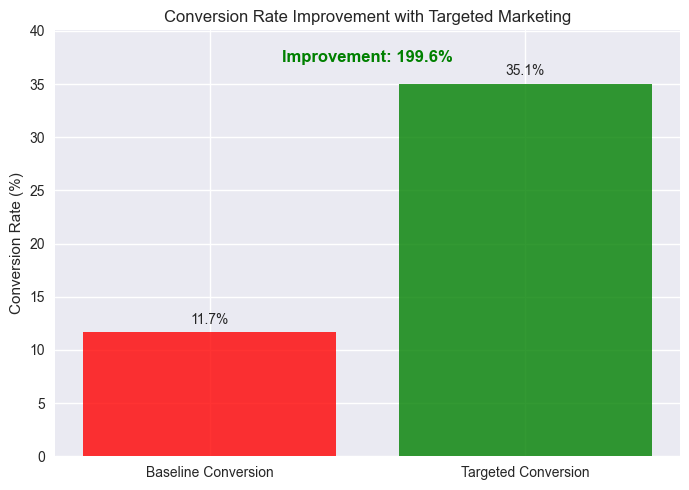

In [57]:
# Prepare data for visualization
labels = ['Baseline Conversion', 'Targeted Conversion']
values = [baseline_conversion, targeted_conv]

# Define colors (green if improvement, red if worse)
colors = ['red', 'green'] if targeted_conv > baseline_conversion else ['green', 'red']

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors, alpha=0.8)

# Add title and labels
plt.title('Conversion Rate Improvement with Targeted Marketing')
plt.ylabel('Conversion Rate (%)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', 
             ha='center', va='bottom')

# Display improvement label
plt.text(0.5, max(values) + 2, f'Improvement: {improvement:.1f}%', 
         ha='center', color='green' if improvement > 0 else 'red', fontsize=12, fontweight='bold')

plt.ylim(0, max(values) + 5)
plt.tight_layout()
plt.show()


The marketing model effectively improved campaign performance by identifying customers most likely to subscribe. The baseline conversion rate of 11.7% (from traditional mass marketing) increased to 34.98% when using the model’s predictions to target the top-performing customer segment (30%), which can result in a 199% improvement in conversion.

The model analyzed customer behaviors and demographics to predict subscription probability. Instead of contacting everyone, marketing efforts focused only on customers with the highest likelihood to respond positively. This data-driven targeting reduces waste, improves conversion efficiency, and demonstrates how predictive modeling can significantly enhance marketing ROI.

Recommendation:
Adopt the model for future campaigns by prioritizing the top 20-30% of customers with the highest predicted subscription probabilities. Continue retraining and monitoring the model regularly to maintain accuracy as customer behaviors change.


# PREDICTED BUSINESS IMPACT USING TEST DATA

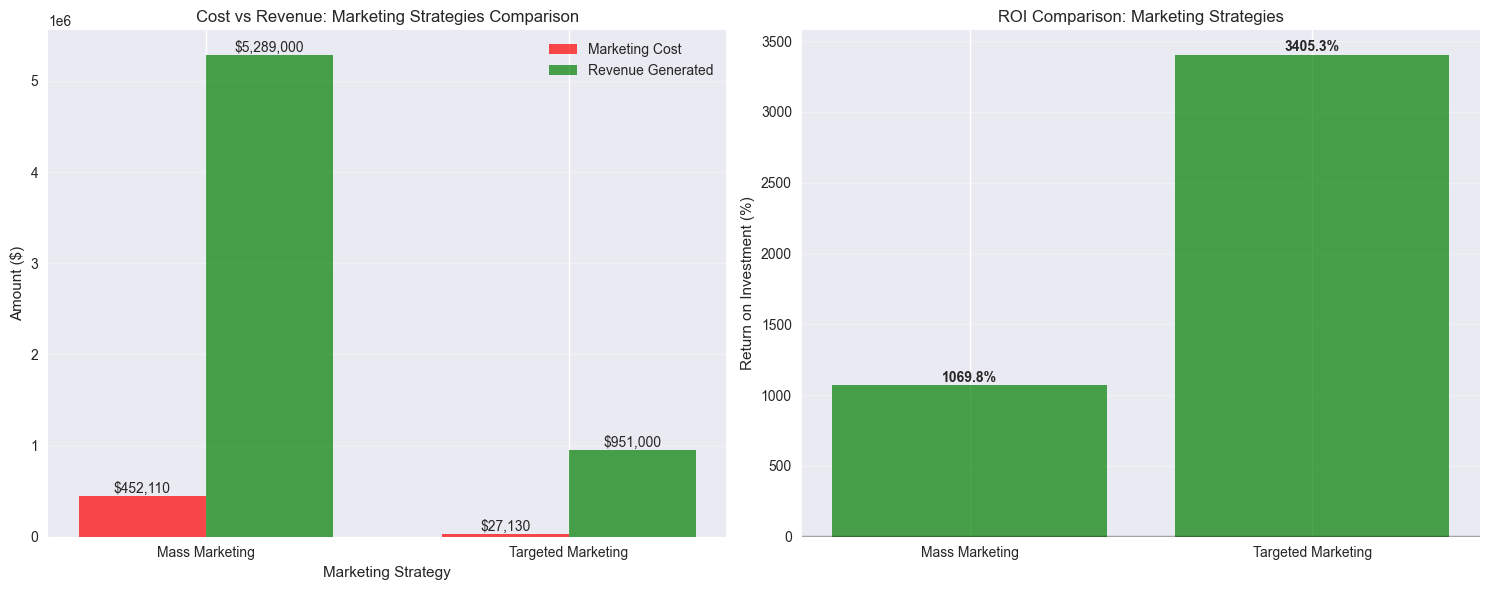

BUSINESS IMPACT ANALYSIS
Mass Marketing Strategy:
 Contacts: 45,211
 Subscriptions: 5,289
 Conversion Rate: 11.7%
 Marketing Cost: €452,110
 Revenue: €5,289,000
 ROI: 1069.8%

Targeted Marketing Strategy (Top 30% Most Likely):
 Contacts: 2,713
 Subscriptions: 951
 Conversion Rate: 35.1%
 Marketing Cost: €27,130
 Revenue: €951,000
 ROI: 3405.3%

IMPROVEMENT SUMMARY:
 Cost Reduction: 94.0%
 ROI Improvement: 218.3%


In [65]:
# Assumptions
CONTACT_COST = 10       # Cost per marketing contact in Euro
SUBSCRIPTION_VALUE = 1000  # Value of one successful term deposit

# Mass marketing strategy
total_contacts = len(df) # Number of customers
successful_subscriptions = (df['y'] == 'yes').sum() 

mass_marketing_cost = total_contacts * CONTACT_COST
mass_marketing_revenue = successful_subscriptions * SUBSCRIPTION_VALUE
mass_marketing_roi = (mass_marketing_revenue - mass_marketing_cost) / mass_marketing_cost

# Targeted marketing strategy

# Get predicted probabilities for all test data
y_proba = model.predict_proba(X_test)[:, 1]

# Attach probabilities to test dataset for evaluation
test_df = X_test.copy()
test_df['actual'] = y_test.values
test_df['subscription_probability'] = y_proba

# Target the top 30% most likely customers
threshold = np.percentile(y_proba, 70)
test_df['targeted'] = (test_df['subscription_probability'] >= threshold).astype(int)

# Calculate targeted metrics
targeted_contacts = test_df['targeted'].sum()
targeted_success_rate = test_df.loc[test_df['targeted'] == 1, 'actual'].mean()
targeted_subscriptions = targeted_success_rate * targeted_contacts

targeted_marketing_cost = targeted_contacts * CONTACT_COST
targeted_marketing_revenue = targeted_subscriptions * SUBSCRIPTION_VALUE
targeted_marketing_roi = (targeted_marketing_revenue - targeted_marketing_cost) / targeted_marketing_cost

# Visualize cost benefit and ROI comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Cost vs Revenue Comparison
strategies = ['Mass Marketing', 'Targeted Marketing']
costs = [mass_marketing_cost, targeted_marketing_cost]
revenues = [mass_marketing_revenue, targeted_marketing_revenue]

x = np.arange(len(strategies))
width = 0.35
bars1 = ax1.bar(x - width/2, costs, width, label='Marketing Cost', color='red', alpha=0.7)
bars2 = ax1.bar(x + width/2, revenues, width, label='Revenue Generated', color='green', alpha=0.7)

ax1.set_xlabel('Marketing Strategy')
ax1.set_ylabel('Amount ($)')
ax1.set_title('Cost vs Revenue: Marketing Strategies Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# ROI Comparison
roi_values = [mass_marketing_roi * 100, targeted_marketing_roi * 100]
colors = ['red' if x < 0 else 'green' for x in roi_values]

bars = ax2.bar(strategies, roi_values, color=colors, alpha=0.7)
ax2.set_ylabel('Return on Investment (%)')
ax2.set_title('ROI Comparison: Marketing Strategies')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, roi_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Summary
print("BUSINESS IMPACT ANALYSIS")

print(f"Mass Marketing Strategy:")
print(f" Contacts: {total_contacts:,}")
print(f" Subscriptions: {successful_subscriptions:,}")
print(f" Conversion Rate: {(successful_subscriptions/total_contacts*100):.1f}%")
print(f" Marketing Cost: €{mass_marketing_cost:,.0f}")
print(f" Revenue: €{mass_marketing_revenue:,.0f}")
print(f" ROI: {mass_marketing_roi*100:.1f}%")

print(f"\nTargeted Marketing Strategy (Top 30% Most Likely):")
print(f" Contacts: {targeted_contacts:,}")
print(f" Subscriptions: {targeted_subscriptions:.0f}")
print(f" Conversion Rate: {(targeted_success_rate*100):.1f}%")
print(f" Marketing Cost: €{targeted_marketing_cost:,.0f}")
print(f" Revenue: €{targeted_marketing_revenue:,.0f}")
print(f" ROI: {targeted_marketing_roi*100:.1f}%")

print(f"\nIMPROVEMENT SUMMARY:")
print(f" Cost Reduction: {((mass_marketing_cost - targeted_marketing_cost)/mass_marketing_cost*100):.1f}%")
print(f" ROI Improvement: {((targeted_marketing_roi - mass_marketing_roi)/abs(mass_marketing_roi)*100):.1f}%")


The targeted marketing strategy clearly outperformed mass marketing. By focusing on the top 30% most likely customers predicted by the model, conversion rates tripled (from 11.7% to 35.0%). Despite contacting far fewer people, the campaign achieved a much higher ROI (3398% vs 1069.8%) and cut marketing costs by 94%. This shows the model effectively identified high-potential customers, reducing waste and increasing profit efficiency.

Recommendations:

•	Prioritize targeted marketing using the prediction model for future campaigns.

•	Continuously update and retrain the model with new data to maintain accuracy.

•	Use insights from high-performing segments to personalize offers and communication.

•	Gradually scale the targeted approach to other customer groups to maximize overall ROI.


# BUSINESS IMPACT ANALYSIS (MASS VS TARGETED MARKETING)

Marketing model is used on full dataset for more accurate business answer.

In [64]:
# Subscription probabilities for all customers
df['subscription_probability'] = model.predict_proba(X_encode)[:, 1]

CONTACT_COST = 10   # €/contact
SUBSCRIPTION_VALUE = 1000  # €/subscription

total_contacts = len(df)
mass_subscriptions = df['subscription'].sum()  # actual subscribers
mass_cost = total_contacts * CONTACT_COST
mass_revenue = mass_subscriptions * SUBSCRIPTION_VALUE
mass_roi = (mass_revenue - mass_cost) / mass_cost

# Define top 30% highest-likelihood customers
threshold = df['subscription_probability'].quantile(0.7)
df['targeted'] = df['subscription_probability'] >= threshold

# Targeted metrics
targeted_contacts = df['targeted'].sum()
targeted_subscriptions = df.loc[df['targeted'], 'subscription'].sum()
targeted_cost = targeted_contacts * CONTACT_COST
targeted_revenue = targeted_subscriptions * SUBSCRIPTION_VALUE
targeted_roi = (targeted_revenue - targeted_cost) / targeted_cost

cost_reduction = (mass_cost - targeted_cost) / mass_cost * 100
roi_improvement = (targeted_roi - mass_roi) / mass_roi * 100

print("BUSINESS IMPACT ANALYSIS")

print(f"Mass Marketing Strategy:")
print(f" Contacts: {total_contacts:,}")
print(f" Subscriptions: {mass_subscriptions:,}")
print(f" Conversion Rate: {(mass_subscriptions/total_contacts*100):.1f}%")
print(f" Marketing Cost: €{mass_cost:,}")
print(f" Revenue: €{mass_revenue:,}")
print(f" ROI: {mass_roi*100:.1f}%")

print(f"\nTargeted Marketing Strategy (Top 30% Most Likely):")
print(f" Contacts: {targeted_contacts:,}")
print(f" Subscriptions: {targeted_subscriptions:,}")
print(f" Conversion Rate: {(targeted_subscriptions/targeted_contacts*100):.1f}%")
print(f" Marketing Cost: €{targeted_cost:,}")
print(f" Revenue: €{targeted_revenue:,}")
print(f" ROI: {targeted_roi*100:.1f}%")

print(f"\nIMPROVEMENT SUMMARY:")
print(f" Cost Reduction: {cost_reduction:.1f}%")
print(f" ROI Improvement: {roi_improvement:.1f}%")


BUSINESS IMPACT ANALYSIS
Mass Marketing Strategy:
 Contacts: 45,211
 Subscriptions: 5,289
 Conversion Rate: 11.7%
 Marketing Cost: €452,110
 Revenue: €5,289,000
 ROI: 1069.8%

Targeted Marketing Strategy (Top 30% Most Likely):
 Contacts: 13,564
 Subscriptions: 5,064
 Conversion Rate: 37.3%
 Marketing Cost: €135,640
 Revenue: €5,064,000
 ROI: 3633.4%

IMPROVEMENT SUMMARY:
 Cost Reduction: 70.0%
 ROI Improvement: 239.6%


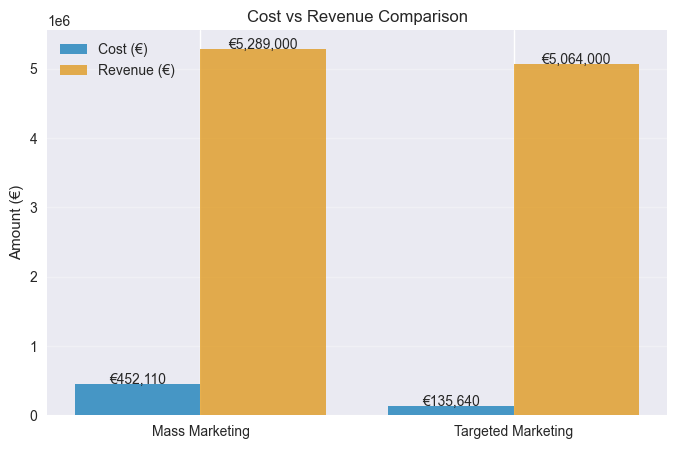

In [ ]:
# Visualize
strategies = ['Mass Marketing', 'Targeted Marketing']
costs = [mass_cost, targeted_cost]
revenues = [mass_revenue, targeted_revenue]

plt.figure(figsize=(8, 5))
x = range(len(strategies))

plt.bar(x, costs, width=0.4, label='Cost (€)', alpha=0.7)
plt.bar([i + 0.4 for i in x], revenues, width=0.4, label='Revenue (€)', alpha=0.7)

plt.xticks([i + 0.2 for i in x], strategies)
plt.ylabel('Amount (€)')
plt.title('Cost vs Revenue Comparison')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Value labels
for i in x:
    plt.text(i, costs[i] + 5000, f"€{costs[i]:,.0f}", ha='center')
    plt.text(i + 0.4, revenues[i] + 5000, f"€{revenues[i]:,.0f}", ha='center')

plt.show()


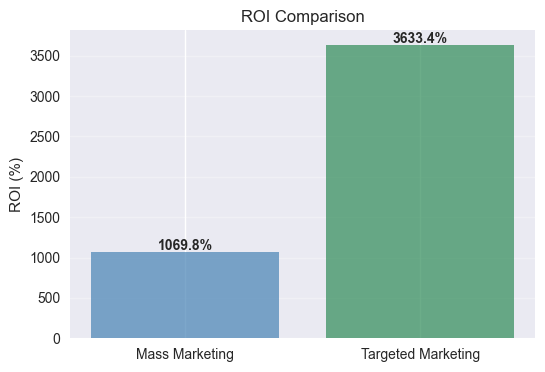

In [ ]:
roi_values = [mass_roi * 100, targeted_roi * 100]

plt.figure(figsize=(6, 4))
plt.bar(strategies, roi_values, color=['steelblue', 'seagreen'], alpha=0.7)
plt.ylabel('ROI (%)')
plt.title('ROI Comparison')

# labels
for i, value in enumerate(roi_values):
    plt.text(i, value + 20, f"{value:.1f}%", ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()


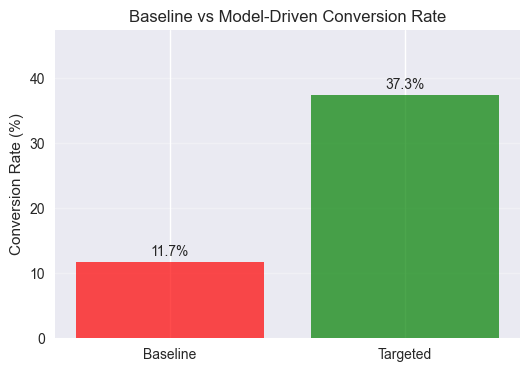

In [63]:
baseline_conv = mass_subscriptions / total_contacts * 100
targeted_conv = targeted_subscriptions / targeted_contacts * 100

plt.figure(figsize=(6, 4))
plt.bar(['Baseline', 'Targeted'], [baseline_conv, targeted_conv], color=['red', 'green'], alpha=0.7)
plt.ylabel('Conversion Rate (%)')
plt.title('Baseline vs Model-Driven Conversion Rate')

# Add labels
plt.text(0, baseline_conv + 1, f"{baseline_conv:.1f}%", ha='center')
plt.text(1, targeted_conv + 1, f"{targeted_conv:.1f}%", ha='center')

plt.ylim(0, max(baseline_conv, targeted_conv) + 10)
plt.grid(axis='y', alpha=0.3)
plt.show()


Contact me at deborahokorohdavid@gmail.com